# Call Center Data -- SARIMA

# Process and Visualize Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
df_data = pd.read_csv("call_center.csv")
df = df_data.copy()

In [4]:
df.head()

,Unnamed: 0,Date,time_24,Queue,Skill,Offered,Handled,Abandon,AnsInSvcl,AnsMinutes,AHT,Talk,Hold,Wrap,Service Level,ASA
0,0,9/15/19,0:00:00,ETS,Gas Emerg 201 ...,1,1,0,1,2,243,241,0,2,1.0,2
1,1,9/15/19,1:00:00,ETS,Gas Emerg 201 ...,1,1,0,1,2,282,277,0,5,1.0,2
2,2,9/15/19,2:30:00,ETS,Gas Emerg 201 ...,1,1,0,1,2,332,212,113,7,1.0,2
3,3,9/15/19,8:30:00,ETS,Gas Emerg 201 ...,1,1,0,1,2,27,0,0,27,1.0,2
4,4,9/15/19,9:00:00,ETS,Gas Emerg 201 ...,2,2,0,2,2,182,177,0,5,1.0,1


In [2]:
# pre-process the time stamp
df['Date'] = df['Date'].apply(lambda x: x[2:] if x[:2]=='20' else x)
# Group data by number of listings per date
df_example = df.groupby(by = 'Date').agg({'Offered': 'count'})
df_example.index

Index(['01/1/17', '01/1/18', '01/1/19', '01/10/17', '01/10/18', '01/10/19',
       '01/11/17', '01/11/18', '01/11/19', '01/12/17',
       ...
       '9/26/17', '9/26/18', '9/27/17', '9/27/18', '9/28/17', '9/28/18',
       '9/29/17', '9/29/18', '9/30/17', '9/30/18'],
      dtype='object', name='Date', length=987)

In [3]:
df_example.index = pd.to_datetime(df_example.index)
# Sort the values
df_example = df_example.sort_index(ascending = True)
df_example.head()

,Offered
Date,
2017-01-01,64
2017-01-02,67
2017-01-03,219
2017-01-04,214
2017-01-05,190


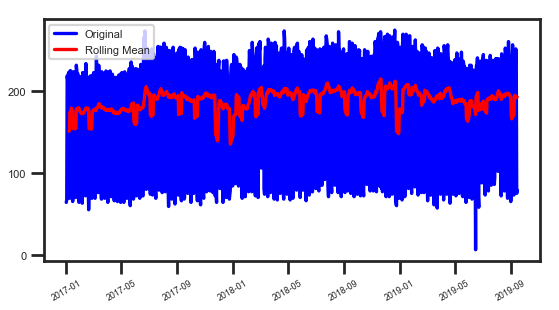

In [183]:
import warnings
warnings.filterwarnings('ignore')
plt.figure(figsize=(8,4), dpi=80)
# Plot time series data
orig = plt.plot(df_example['Offered'], 
                    color = 'blue', 
                    label = 'Original')
rolmean = df_example['Offered'].rolling(window = 7, center = False).mean()
mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
plt.legend(loc = 'best')
plt.xticks(rotation = 45)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.xticks(rotation=30)
plt.legend(loc='upper left', fontsize=10)
plt.show(block = False)
plt.close()

# Decomposition

<Figure size 640x320 with 0 Axes>

<Figure size 432x288 with 0 Axes>

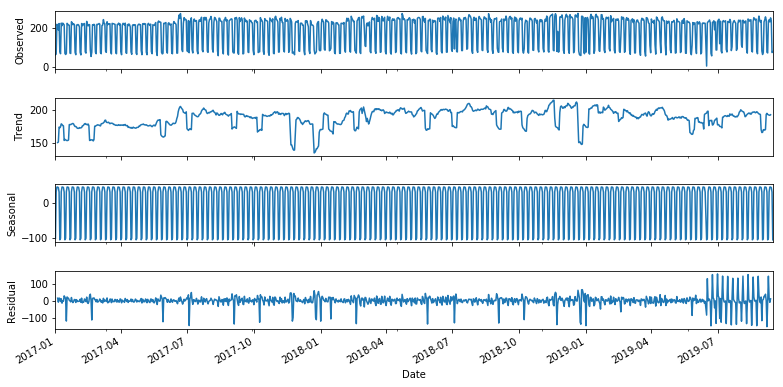

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
plt.figure(figsize=(8,4), dpi=80)
decomposition = seasonal_decompose(df_example['Offered'], freq=7)  
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(12, 6)

Observation  
• Strong Seasonality  
• Slight Trend

# Stationary Check

In [5]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(df, ts):
    """
    Test stationarity using moving average statistics and Dickey-Fuller test
    Source: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/
    """
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Original')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

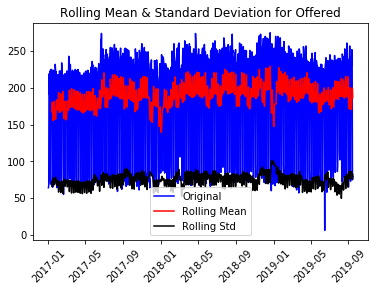

Results of Dickey-Fuller Test:
Test Statistic                  -4.699756
p-value                          0.000084
# Lags Used                     20.000000
Number of Observations Used    966.000000
Critical Value (1%)             -3.437138
Critical Value (5%)             -2.864537
Critical Value (10%)            -2.568366
dtype: float64


In [6]:
test_stationarity(df = df_example, ts = 'Offered')

Observation:  
p << 0.05, Data is stationary (but have seasonality)

# ACF and PACF

In [7]:
# Transformation 
# log: stable the varaince
df_example['log'] = df_example['Offered'].apply(lambda x: np.log(x))
# diff: remove the trend
df_example['diff'] = df_example['Offered'].diff()
df_example['log_diff'] = df_example['log'].diff()
df_example['diff_diff'] = df_example['diff'].diff()

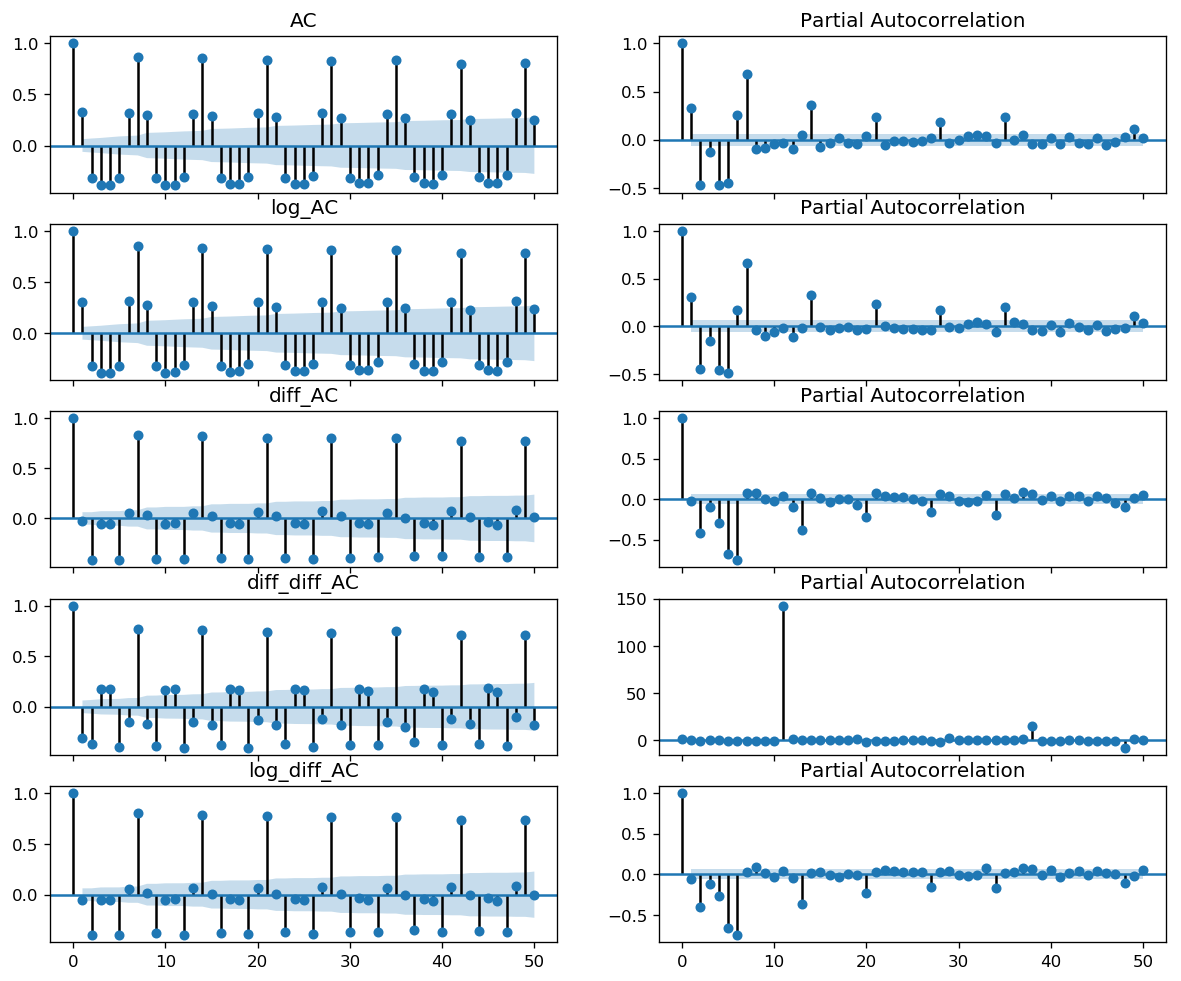

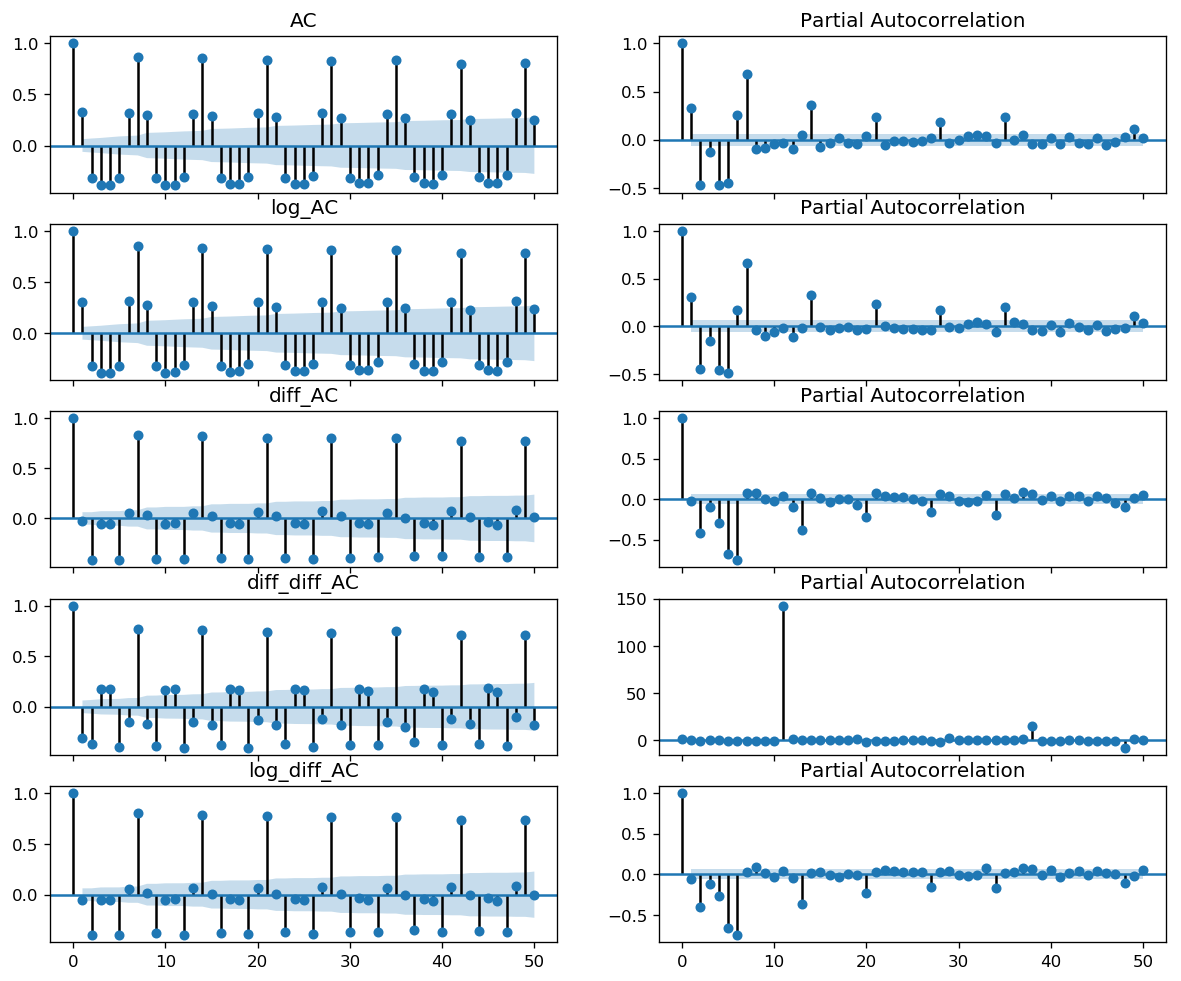

In [11]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.figsize':(12,10), 'figure.dpi':120})
fig, axes = plt.subplots(5, 2, sharex=True)
plot_acf(df_example['Offered'].dropna(),lags=50, ax=axes[0, 0],title = 'AC')
plot_pacf(df_example['Offered'].dropna(),lags=50, ax=axes[0, 1])
plot_acf(df_example['log'].dropna(),lags=50, ax=axes[1, 0],title = 'log_AC')
plot_pacf(df_example['log'].dropna(),lags=50, ax=axes[1, 1])
plot_acf(df_example['diff'].dropna(),lags=50, ax=axes[2, 0],title = 'diff_AC')
plot_pacf(df_example['diff'].dropna(),lags=50, ax=axes[2, 1])
plot_acf(df_example['diff_diff'].dropna(),lags=50, ax=axes[3, 0],title = 'diff_diff_AC')
plot_pacf(df_example['diff_diff'].dropna(),lags=50, ax=axes[3, 1])
plot_acf(df_example['log_diff'].dropna(),lags=50, ax=axes[4, 0],title = 'log_diff_AC')
plot_pacf(df_example['log_diff'].dropna(),lags=50, ax=axes[4, 1])

Conclusion:  
• Seasonality frequency is 7  
• 1 order diff seems the best 

# Building a Seasonal ARIMA Model for Forecasting

In [12]:
# Create a training sample and testing sample before analyzing the series
n_sample = df_example.shape[0]
n_train=int(0.95*n_sample)+1
n_forecast=n_sample-n_train
#ts_df
ts_train = df_example.iloc[:n_train]['Offered']
ts_test = df_example.iloc[n_train:]['Offered']
print(ts_train.shape)
print(ts_test.shape)
print("Training Series:", "\n", ts_train.tail(), "\n")
print("Testing Series:", "\n", ts_test.head())

(938,)
(49,)
Training Series: 
 Date
2019-07-24    238
2019-07-25    230
2019-07-26    225
2019-07-27     86
2019-07-28     95
Name: Offered, dtype: int64 

Testing Series: 
 Date
2019-07-29    222
2019-07-30    240
2019-07-31    232
2019-08-01    240
2019-08-02    238
Name: Offered, dtype: int64


Model Selection

In [13]:
from __future__ import absolute_import, division, print_function

import sys
import os

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import itertools
import warnings

# Display and Plotting
import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.5f' % x) # pandas
np.set_printoptions(precision=5, suppress=True) # numpy

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# seaborn plotting style
sns.set(style='ticks', context='poster')

In [14]:
def model_resid_stats(model_results,
                      het_method='breakvar',
                      norm_method='jarquebera',
                      sercor_method='ljungbox',
                      verbose=True,
                      ):
    '''More information about the statistics under the ARIMA parameters table, tests of standardized residuals:
    
    Test of heteroskedasticity
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_heteroskedasticity

    Test of normality (Default: Jarque-Bera)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality.html#statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_normality

    Test of serial correlation (Default: Ljung-Box)
    http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAXResults.test_serial_correlation.html
    '''
    # Re-run the ARIMA model statistical tests, and more. To be used when selecting viable models.
    (het_stat, het_p) = model_results.test_heteroskedasticity(het_method)[0]
    norm_stat, norm_p, skew, kurtosis = model_results.test_normality(norm_method)[0]
    sercor_stat, sercor_p = model_results.test_serial_correlation(method=sercor_method)[0]
    sercor_stat = sercor_stat[-1] # last number for the largest lag
    sercor_p = sercor_p[-1] # last number for the largest lag

    # Run Durbin-Watson test on the standardized residuals.
    # The statistic is approximately equal to 2*(1-r), where r is the sample autocorrelation of the residuals.
    # Thus, for r == 0, indicating no serial correlation, the test statistic equals 2.
    # This statistic will always be between 0 and 4. The closer to 0 the statistic,
    # the more evidence for positive serial correlation. The closer to 4,
    # the more evidence for negative serial correlation.
    # Essentially, below 1 or above 3 is bad.
    dw_stat = sm.stats.stattools.durbin_watson(model_results.filter_results.standardized_forecasts_error[0, model_results.loglikelihood_burn:])

    # check whether roots are outside the unit circle (we want them to be);
    # will be True when AR is not used (i.e., AR order = 0)
    arroots_outside_unit_circle = np.all(np.abs(model_results.arroots) > 1)
    # will be True when MA is not used (i.e., MA order = 0)
    maroots_outside_unit_circle = np.all(np.abs(model_results.maroots) > 1)
    
    if verbose:
        print('Test heteroskedasticity of residuals ({}): stat={:.3f}, p={:.3f}'.format(het_method, het_stat, het_p));
        print('\nTest normality of residuals ({}): stat={:.3f}, p={:.3f}'.format(norm_method, norm_stat, norm_p));
        print('\nTest serial correlation of residuals ({}): stat={:.3f}, p={:.3f}'.format(sercor_method, sercor_stat, sercor_p));
        print('\nDurbin-Watson test on residuals: d={:.2f}\n\t(NB: 2 means no serial correlation, 0=pos, 4=neg)'.format(dw_stat))
        print('\nTest for all AR roots outside unit circle (>1): {}'.format(arroots_outside_unit_circle))
        print('\nTest for all MA roots outside unit circle (>1): {}'.format(maroots_outside_unit_circle))
    
    stat = {'het_method': het_method,
            'het_stat': het_stat,
            'het_p': het_p,
            'norm_method': norm_method,
            'norm_stat': norm_stat,
            'norm_p': norm_p,
            'skew': skew,
            'kurtosis': kurtosis,
            'sercor_method': sercor_method,
            'sercor_stat': sercor_stat,
            'sercor_p': sercor_p,
            'dw_stat': dw_stat,
            'arroots_outside_unit_circle': arroots_outside_unit_circle,
            'maroots_outside_unit_circle': maroots_outside_unit_circle,
            }
    return stat

In [15]:
def model_gridsearch(ts,
                     p_min,
                     d_min,
                     q_min,
                     p_max,
                     d_max,
                     q_max,
                     sP_min,
                     sD_min,
                     sQ_min,
                     sP_max,
                     sD_max,
                     sQ_max,
                     trends,
                     s=None,
                     enforce_stationarity=True,
                     enforce_invertibility=True,
                     simple_differencing=False,
                     plot_diagnostics=False,
                     verbose=False,
                     filter_warnings=True,
                    ):
    '''Run grid search of SARIMAX models and save results.
    '''
    
    cols = ['p', 'd', 'q', 'sP', 'sD', 'sQ', 's', 'trend',
            'enforce_stationarity', 'enforce_invertibility', 'simple_differencing',
            'aic', 'bic',
            'het_p', 'norm_p', 'sercor_p', 'dw_stat',
            'arroots_gt_1', 'maroots_gt_1',
            'datetime_run']

    # Initialize a DataFrame to store the results
    df_results = pd.DataFrame(columns=cols)

    # # Initialize a DataFrame to store the results
    # results_bic = pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
    #                            columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

    mod_num=0
    for trend,p,d,q,sP,sD,sQ in itertools.product(trends,
                                                  range(p_min,p_max+1),
                                                  range(d_min,d_max+1),
                                                  range(q_min,q_max+1),
                                                  range(sP_min,sP_max+1),
                                                  range(sD_min,sD_max+1),
                                                  range(sQ_min,sQ_max+1),
                                                  ):
        # initialize to store results for this parameter set
        this_model = pd.DataFrame(index=[mod_num], columns=cols)

        if p==0 and d==0 and q==0:
            continue

        try:
            model = sm.tsa.SARIMAX(ts,
                                   trend=trend,
                                   order=(p, d, q),
                                   seasonal_order=(sP, sD, sQ, s),
                                   enforce_stationarity=enforce_stationarity,
                                   enforce_invertibility=enforce_invertibility,
                                   simple_differencing=simple_differencing,
                                  )
            
            if filter_warnings is True:
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore")
                    model_results = model.fit(disp=0)
            else:
                model_results = model.fit()

            if verbose:
                print(model_results.summary())

            if plot_diagnostics:
                model_results.plot_diagnostics();

            stat = model_resid_stats(model_results,
                                     verbose=verbose)

            this_model.loc[mod_num, 'p'] = p
            this_model.loc[mod_num, 'd'] = d
            this_model.loc[mod_num, 'q'] = q
            this_model.loc[mod_num, 'sP'] = sP
            this_model.loc[mod_num, 'sD'] = sD
            this_model.loc[mod_num, 'sQ'] = sQ
            this_model.loc[mod_num, 's'] = s
            this_model.loc[mod_num, 'trend'] = trend
            this_model.loc[mod_num, 'enforce_stationarity'] = enforce_stationarity
            this_model.loc[mod_num, 'enforce_invertibility'] = enforce_invertibility
            this_model.loc[mod_num, 'simple_differencing'] = simple_differencing

            this_model.loc[mod_num, 'aic'] = model_results.aic
            this_model.loc[mod_num, 'bic'] = model_results.bic

            # this_model.loc[mod_num, 'het_method'] = stat['het_method']
            # this_model.loc[mod_num, 'het_stat'] = stat['het_stat']
            this_model.loc[mod_num, 'het_p'] = stat['het_p']
            # this_model.loc[mod_num, 'norm_method'] = stat['norm_method']
            # this_model.loc[mod_num, 'norm_stat'] = stat['norm_stat']
            this_model.loc[mod_num, 'norm_p'] = stat['norm_p']
            # this_model.loc[mod_num, 'skew'] = stat['skew']
            # this_model.loc[mod_num, 'kurtosis'] = stat['kurtosis']
            # this_model.loc[mod_num, 'sercor_method'] = stat['sercor_method']
            # this_model.loc[mod_num, 'sercor_stat'] = stat['sercor_stat']
            this_model.loc[mod_num, 'sercor_p'] = stat['sercor_p']
            this_model.loc[mod_num, 'dw_stat'] = stat['dw_stat']
            this_model.loc[mod_num, 'arroots_gt_1'] = stat['arroots_outside_unit_circle']
            this_model.loc[mod_num, 'maroots_gt_1'] = stat['maroots_outside_unit_circle']

            this_model.loc[mod_num, 'datetime_run'] = pd.to_datetime('today').strftime('%Y-%m-%d %H:%M:%S')

            df_results = df_results.append(this_model)
            mod_num+=1
        except:
            continue
    return df_results

In [16]:
import warnings
warnings.filterwarnings('ignore')

# run model grid search

p_min = 0
d_min = 0
q_min = 0
p_max = 2
d_max = 1
q_max = 2

sP_min = 0
sD_min = 0
sQ_min = 0
sP_max = 1
sD_max = 1
sQ_max = 1

s=7

# trends=['n', 'c']
trends=['n']

enforce_stationarity=True
enforce_invertibility=True
simple_differencing=False

plot_diagnostics=False

verbose=False

df_results = model_gridsearch(ts_train,
                              p_min,
                              d_min,
                              q_min,
                              p_max,
                              d_max,
                              q_max,
                              sP_min,
                              sD_min,
                              sQ_min,
                              sP_max,
                              sD_max,
                              sQ_max,
                              trends,
                              s=s,
                              enforce_stationarity=enforce_stationarity,
                              enforce_invertibility=enforce_invertibility,
                              simple_differencing=simple_differencing,
                              plot_diagnostics=plot_diagnostics,
                              verbose=verbose,
                              )

Choose a model based on:  
• A criterion, e.g., AIC, BIC  
• Examination of statistical tests on residuals  
• Out-of-sample forecast error.

In [17]:
# choose a model based on AIC
df_results.sort_values(by='bic').head(10)

,p,d,q,sP,sD,sQ,s,trend,enforce_stationarity,enforce_invertibility,simple_differencing,aic,bic,het_p,norm_p,sercor_p,dw_stat,arroots_gt_1,maroots_gt_1,datetime_run
3,0,0,1,0,1,1,7,n,True,True,False,9000.95796,9015.46674,0.00000,0.00000,0.43057,2.00297,True,True,2020-07-15 17:51:19
39,1,0,0,0,1,1,7,n,True,True,False,9002.07996,9016.58873,0.00000,0.00000,0.41919,1.98714,True,True,2020-07-15 17:51:40
7,0,0,1,1,1,1,7,n,True,True,False,9002.06334,9021.40838,0.00000,0.00000,0.43417,2.00314,True,True,2020-07-15 17:51:22
74,2,0,0,0,1,1,7,n,True,True,False,9002.45160,9021.79663,0.00000,0.00000,0.41592,2.00091,True,True,2020-07-15 17:52:04
11,0,0,2,0,1,1,7,n,True,True,False,9002.79536,9022.14039,0.00000,0.00000,0.41527,1.99843,True,True,2020-07-15 17:51:23
47,1,0,1,0,1,1,7,n,True,True,False,9002.83706,9022.18209,0.00000,0.00000,0.41976,1.99981,True,True,2020-07-15 17:51:44
43,1,0,0,1,1,1,7,n,True,True,False,9003.15450,9022.49954,0.00000,0.00000,0.42379,1.98755,True,True,2020-07-15 17:51:42
33,0,1,2,0,1,1,7,n,True,True,False,9003.33995,9022.68069,0.00000,0.00000,0.43213,1.99176,True,True,2020-07-15 17:51:36
67,1,1,1,0,1,1,7,n,True,True,False,9004.42681,9023.76755,0.00000,0.00000,0.42050,1.97586,True,True,2020-07-15 17:51:58
53,1,0,2,0,1,1,7,n,True,True,False,9002.78492,9026.96621,0.00001,0.00000,0.50906,1.99662,True,True,2020-07-15 17:51:50


Model Diagnostic

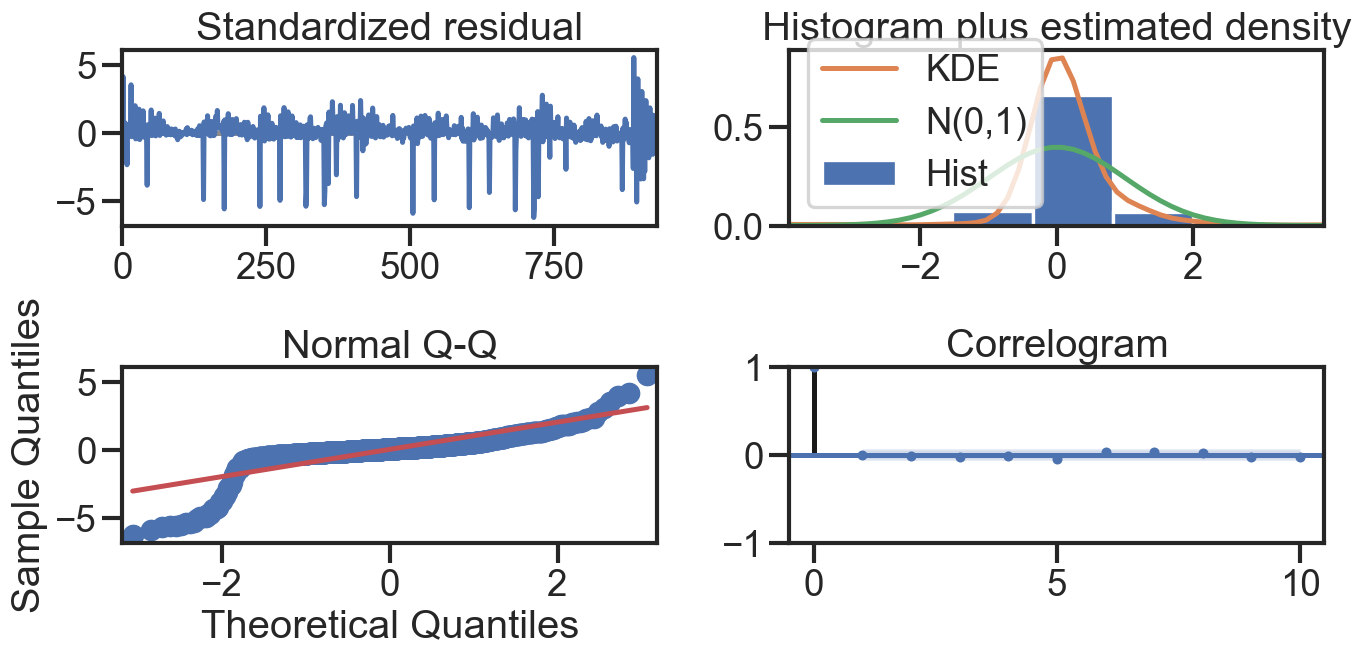

In [25]:
import warnings
warnings.filterwarnings('ignore')

#fit the model
my_order = (0,0,1)
my_seasonal_order = (0, 1, 1, 7)
model = sm.tsa.SARIMAX(ts_train, order=my_order, seasonal_order=my_seasonal_order)
model_fit = model.fit()


fig = model_fit.plot_diagnostics(figsize=(12,6))
fig.tight_layout()

Observation:  (Ask Aaron)  
• The mean of residual is around 0  
• The distribution of density is normal with the mean that close to 0  
• Normal Q-Q?  
• No correlation exist in residual

# Forecast

Using optimal trained model for forecasting

In [26]:
import warnings
warnings.filterwarnings('ignore')
pred = model_fit.forecast(49, alpha=0.05)

Forecasting each time stamp by ultilizing all previous data (including predicted data)  
Using the same parameter

In [21]:
import warnings
from datetime import timedelta
warnings.filterwarnings('ignore')
from statsmodels.tsa.statespace.sarimax import SARIMAX
rolling_predictions = ts_test.copy()
for train_end in ts_test.index:
    train_data = df_example['Offered'][:train_end-timedelta(days=1)]
    model = SARIMAX(train_data, order=my_order, seasonal_order=my_seasonal_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_predictions[train_end] = pred

Comparison

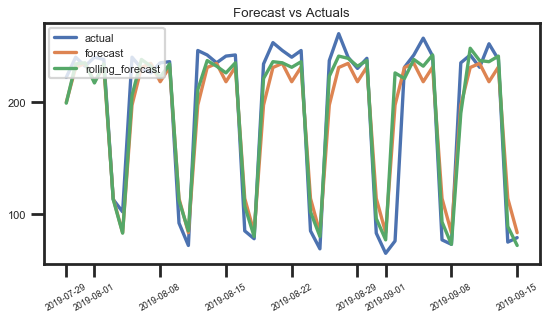

In [28]:
# Make as pandas series
fc_series = pd.Series(pred.values, index=ts_test.index)
# rolling_series = pd.Series(rolling_predictions.values, index=ts_test.index)
# lower_series = pd.Series(conf[:, 0], index=ts_test.index)
# upper_series = pd.Series(conf[:, 1], index=ts_test.index)

# Plot
plt.figure(figsize=(8,4), dpi=80)
# plt.plot(ts_train, label='training')
plt.plot(ts_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.plot(rolling_predictions, label='rolling_forecast')
# plt.plot(rolling_predictions, label='rolling_forecast')
# plt.fill_between(lower_series.index, lower_series, upper_series, 
#                  color='k', alpha=.15)

# plt.fill_between(pred_ci.index,
#                  pred_ci.iloc[:, 0],
#                  pred_ci.iloc[:, 1], color='k', alpha=.2)


plt.title('Forecast vs Actuals',fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.xticks(rotation=30)
plt.show()

In [29]:
rolling_residuals = ts_test - rolling_predictions
residuals = ts_test - fc_series

Text(0, 0.5, 'Residuals Error')

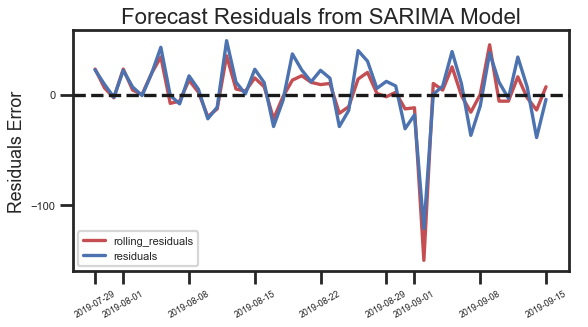

In [30]:
plt.figure(figsize=(8,4), dpi=80)
plt.plot(rolling_residuals,color='r',label='rolling_residuals')
plt.plot(residuals,color='b',label='residuals')
plt.xticks(fontsize=8)
plt.yticks(fontsize=10)
plt.xticks(rotation=30)
plt.legend(loc='lower left', fontsize=10)
plt.axhline(0, linestyle='--', color='k')
plt.title('Forecast Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Residuals Error', fontsize=16)

In [31]:
print('Mean Absolute Percent Error (rolling):', round(np.mean(abs(rolling_residuals/ts_test)),4))
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/ts_test)),4))

Mean Absolute Percent Error (rolling): 0.1162
Mean Absolute Percent Error: 0.1511
